In [1]:
import cv2
import os
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pickle
from PIL import Image, ImageSequence, ImageDraw

from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2, Regularizer
from tensorflow.keras.utils import get_custom_objects
from tensorflow.python.framework import ops

# General Settings

In [2]:
# Number of training epochs
nb_epoch = 50

# Color mode grayscale
channels = 1

# Training details (training date, model name)
sDate = '210715_V2'
model_name = 'VGG16-1_Augmentation_Binary'

# File path
checkPointFilepath = 'D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/KI Demonstrator - Hochschulmodel/Optimierung_Evaluation_Finale_Aufnahmen/01_Checkpoints/{0}_Gleitringdichtungen_{1}.hdf5'.format(sDate, model_name)
heatmaps_path = 'D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/KI Demonstrator - Hochschulmodel/Optimierung_Evaluation_Finale_Aufnahmen/02_Heatmaps/{0}_{1}'.format(model_name, sDate)
filters_path = 'D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/KI Demonstrator - Hochschulmodel/Optimierung_Evaluation_Finale_Aufnahmen/03_Filter/{0}_{1}/'.format(model_name, sDate)
historyFilepath = 'D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/KI Demonstrator - Hochschulmodel/Optimierung_Evaluation_Finale_Aufnahmen/04_History/{0}_Gleitringdichtungen_{1}.pk3'.format(sDate, model_name)
modelPath = 'D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/KI Demonstrator - Hochschulmodel/Optimierung_Evaluation_Finale_Aufnahmen/05_Models/{0}_Gleitringdichtungen_{1}.hdf5'.format(sDate, model_name)

# Helper Functions

In [3]:
# Helper function to preload images from directory
def preload_from_directory(directory_path, target_size=(350, 350)):
    image_list = []
    label_list = []
    class_dictionary = {}
    files_list = []
    class_idx = 0
    
    # Folder names equal the class names
    # Directories are read in one after the other
    class_directories = glob.glob(directory_path + '/*', recursive=True)
    for class_directory in class_directories:
        
        # Name and number for each class
        class_name = os.path.basename(class_directory)
        class_dictionary[class_name] = class_idx
        class_idx += 1
        
        # Read in images for each class
        image_files = glob.glob(class_directory + '/*.tif')
        for image_path in image_files:
            # Pre-Process images for training
            #image = cv2.imread(image_path) #, -1)
            image = Image.open(image_path)#.convert('RGB') 
            
            cropImage = True
            
            #Iterate over different Images in tif file
            for i, page in enumerate(ImageSequence.Iterator(image)):
                #Use Image with complete Lighting
                if i == 4:
                    image = page
                if cropImage == True and i == 4:
            
                    height, width = image.size
                    
                    #Create Mask
                    lum_img = Image.new("L", [height, width], 255)
                    
                    #Lay Mask over irrelevant Areas
                    draw = ImageDraw.Draw(lum_img)
                    draw.pieslice([1100, 630, (2920, 2450)], 0, 360, fill=0, outline="red")

                    draw_inner_circle = ImageDraw.Draw(lum_img)
                    draw_inner_circle.pieslice([1470, 1010, (2540, 2070)], 0, 360, fill=255, outline="red")

                    image.paste(lum_img, (0,0),lum_img)
            
            #Convert to RGB
            image = image.convert('RGB')
            image = np.array(image) 
            # Convert RGB to BGR 
            image = image[:, :, ::-1].copy() 
            plt.imshow(image)
            # Resize
            border_v, border_h = 0, 0
            (IMG_ROW, IMG_COL) = target_size
            if (IMG_COL/IMG_ROW) >= (image.shape[0]/image.shape[1]):
                border_v = int((((IMG_COL/IMG_ROW)*image.shape[1])-image.shape[0])/2)
            else:
                border_h = int((((IMG_ROW/IMG_COL)*image.shape[0])-image.shape[1])/2)
            image = cv2.copyMakeBorder(image, border_v, border_v, border_h, border_h, cv2.BORDER_CONSTANT, value=[128, 128, 128])
            image = cv2.resize(image, (IMG_ROW, IMG_COL))
            
            
            # Transform data into target format
            image = image.astype(np.float64)
            image = preprocess_input(image)
            
            # Create label with one-hot encoding
            label = np.zeros(len(class_directories))
            label[class_dictionary[class_name]] = 1
            
            # Create list
            image_list.append(image)
            label_list.append(label)
            files_list.append(os.path.basename(image_path))
    
    # Convert list to array
    image_nparray = np.asarray(image_list)
    label_nparray = np.asarray(label_list)
    del image_list, label_list
    
    print('Found', image_nparray.shape[0], 'images belonging to', class_idx, 'classes.')
    
    return image_nparray, label_nparray, class_dictionary, files_list

In [4]:
# Class L2SP for Explicit Inductive Bias
class L2SP(Regularizer):
    def __init__(self, alpha=0., beta=0., x0=[]):
        if isinstance(x0, dict):
            x0 = x0['value']
        
        self.alpha = K.cast_to_floatx(alpha)
        self.beta = K.cast_to_floatx(beta)
        self.x0_tensor = K.constant(K.cast_to_floatx(x0))
        self.x0 = x0
    
    def __call__(self, x):
        regularization = 0.
        
        if self.alpha:
            regularization += K.sum(self.alpha / 2 * K.square(x - self.x0_tensor))
        if self.beta:
            regularization += K.sum(self.beta / 2 * K.square(x))
        
        return regularization
    
    def get_config(self):
        return {'alpha': float(self.alpha),
                'beta': float(self.beta),
                'x0': self.x0}

def l2sp(alpha=0., beta=0., x0=[]):
    return L2SP(alpha, beta, x0)

get_custom_objects().update({"L2SP": l2sp})

# Pre-Load Training Data

D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\015.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\016.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\017.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\018.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\019.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\020.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\021.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\022.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\023.tif
D:/Hochsch

D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\090.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\091.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\092.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\093.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\094.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\095.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\096.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\097.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\IO\098.tif
D:/Hochsch

D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\NIO\92.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\NIO\93.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\NIO\94.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\NIO\95.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\NIO\96.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\NIO\97.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training\NIO\98.tif
Found 157 images belonging to 2 classes.
Classes: {'IO': 0, 'NIO': 1}


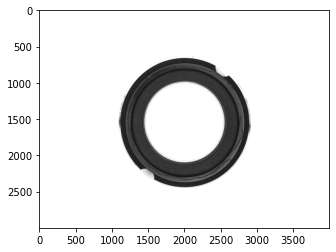

In [5]:
# Pre-load training images from directory
training_images, training_labels, training_classes, training_files = preload_from_directory('D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Training')
print('Classes:', training_classes)

In [6]:
x_train, y_train, x_test, y_test = train_test_split(training_images, training_labels, test_size=0.2)

# Use image data generator for data augmentation and rescaling
train_generator = ImageDataGenerator(rotation_range = 360,
                                     horizontal_flip = True,
                                     width_shift_range = 0.05,
                                     height_shift_range = 0.05,
                                     zoom_range = [1, 1.2],
                                     fill_mode='constant')

train_iterator = train_generator.flow(x_train,
                                      x_test,
                                      batch_size = 32,
                                      shuffle = True)

D:\Tools\Anaconda\envs\KIDemonstrator2\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


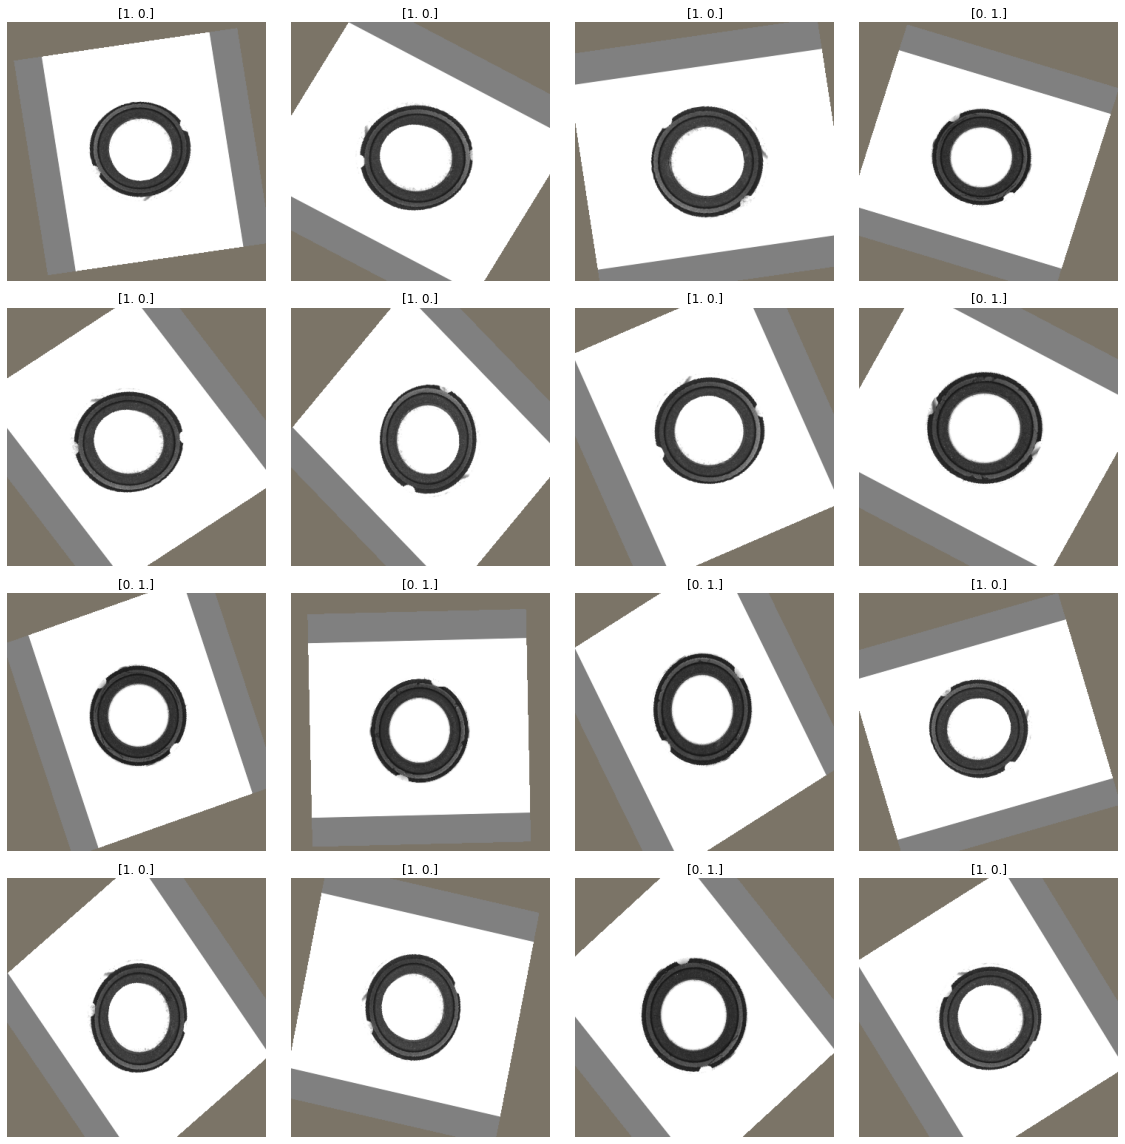

In [7]:
# Generate graphics
images_test, labels_test = train_iterator.next()

# Show graphics
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(labels_test[(i-1)])

    # Pre-process input for display (invert)
    image_test = images_test[(i-1)]
    mean = [103.939, 116.779, 123.68]
    for idx in range(3):
        image_test[:, :, idx] = (image_test[:, :, idx] + mean[idx]) / 255
    image_test = image_test[..., ::-1]
    
    plt.axis('off')
    plt.imshow(image_test)
plt.tight_layout()
plt.show()

# Pre-Load Validation Data

In [8]:
# Use image data generator for some image augmentation
validation_generator = ImageDataGenerator()

validation_iterator = validation_generator.flow(y_train,
                                                y_test,
                                                batch_size = len(y_train),
                                                shuffle = False)

validation_x_images, validation_y_labels = validation_iterator.next()

# Building and Training of CNN with Transfer Learning

In [9]:
# L2-SP learning parameters
alpha = 0.1
beta = 0.01

# Create pretrained Xception model using Imagenet weights, but without the original classifier
model = VGG16(input_shape=(None, None, 3), weights='imagenet', include_top=False)

# Add L2-SP regularizer to pretrained layers
for idx in range(len(model.layers)):
    if isinstance(model.layers[idx], layers.Conv2D):
        model.layers[idx].kernel_regularizer = l2sp(alpha=alpha, x0=model.layers[idx].get_weights()[0])

# Compile to suppress warning
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'])

# Save and load to make new loss work
model.save('temp_vgg.hdf5')
model = load_model('temp_vgg.hdf5')
os.remove('temp_vgg.hdf5')

# Add new classificator
x = model.layers[-1].output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32,
                 activation=None,
                 kernel_regularizer=l2sp(beta=beta),
                 use_bias=False,
                 name='fc1')(x)
x = layers.Dropout(0.8, name='dropout_1')(x)
x = layers.BatchNormalization(name='fc1_bn')(x)
x = layers.Activation('relu', name='fc1_act')(x)
output = layers.Dense(2, activation='sigmoid', name='predictions')(x)
model = Model(model.input, output)

# Usa RMSprop optimizer
optimizer = RMSprop(lr=1e-5)

# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

D:\Tools\Anaconda\envs\KIDemonstrator2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [10]:
# Save the best set of weights during training
model_check = ModelCheckpoint(checkPointFilepath, save_best_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience = 5, restore_best_weights=True)
# Training callbacks
callbacks = [model_check]

# Trains the model with the current train and test split
history = model.fit(train_iterator,
                    validation_data = (validation_x_images, validation_y_labels),
                    steps_per_epoch = 25,
                    epochs = nb_epoch,
                    callbacks = callbacks,
                    workers = 8)

# Save history
with open(historyFilepath, 'wb') as file_history:
    pickle.dump(history.history, file_history)

Epoch 1/50
25/25 [==============================] - 63s 940ms/step - loss: 1.0334 - accuracy: 0.5648 - val_loss: 0.8740 - val_accuracy: 0.5938
Epoch 2/50
25/25 [==============================] - 12s 447ms/step - loss: 0.9300 - accuracy: 0.6932 - val_loss: 0.9073 - val_accuracy: 0.5938
Epoch 3/50
25/25 [==============================] - 11s 433ms/step - loss: 0.8605 - accuracy: 0.8164 - val_loss: 0.7490 - val_accuracy: 1.0000
Epoch 4/50
25/25 [==============================] - 11s 424ms/step - loss: 0.8356 - accuracy: 0.8325 - val_loss: 0.7243 - val_accuracy: 1.0000
Epoch 5/50
25/25 [==============================] - 12s 433ms/step - loss: 0.8169 - accuracy: 0.8504 - val_loss: 0.7387 - val_accuracy: 1.0000
Epoch 6/50
25/25 [==============================] - 11s 435ms/step - loss: 0.8126 - accuracy: 0.8593 - val_loss: 0.8031 - val_accuracy: 0.7500
Epoch 7/50
25/25 [==============================] - 11s 434ms/step - loss: 0.7933 - accuracy: 0.8824 - val_loss: 0.6961 - val_accuracy: 1.0000

In [11]:
# Load the best set of weights
model.load_weights(checkPointFilepath)

# Save complete model with the best sets of weights
# This makes it more convenient to load the model later
model.save(modelPath)

# Evaluation Using Test Data

In [12]:
# Load model
model = load_model(modelPath)

D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Validation\IO\099.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Validation\IO\100.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Validation\IO\101.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Validation\IO\102.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Validation\IO\103.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Validation\NIO\100.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Validation\NIO\101.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Validation\NIO\102.tif
D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Validation\

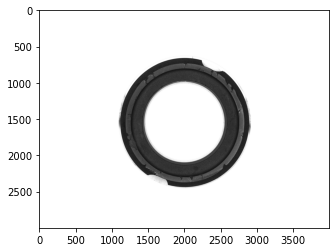

In [13]:
# Pre-load test images
test_images, test_labels, test_classes, test_files = preload_from_directory('D:/Hochschule/Akademischer Mitarbeiter/Forschungsprojekt/Bilder 07.04/Segment_Beleuchtung/Validation', target_size=(350, 350))
print('Classes:', test_classes)

# Use image data generator for some image augmentation
test_generator = ImageDataGenerator()

test_iterator = test_generator.flow(test_images,
                                    test_labels,
                                    batch_size = 15,
                                    shuffle = False)

test_x_images, test_y_labels = test_iterator.next()
labels_classes = np.argmax(test_labels, axis=1)

In [14]:
# Run the Class Predictions and get the probabilities
pred_probas = model.predict(test_x_images, verbose=1, batch_size=12)
predictions = np.argmax(pred_probas, axis=1)

1/1 [==============================] - 1s 1s/step


## Confusion Matrix

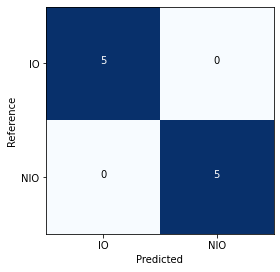

In [15]:
# Helper function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, normalize_color=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(4, 4))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    if normalize_color:
        cm_color = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        plt.imshow(cm_color, interpolation='nearest', cmap=cmap)
    else:
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Reference')
    plt.xlabel('Predicted')
    
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix(labels_classes, predictions), test_classes.keys(), normalize_color=True)

In [16]:
# Calculate the confusion matrix
cnf_matrix = confusion_matrix(labels_classes, predictions)

# Calculate performance indicators
print('Accuracy: %.5f' % accuracy_score(labels_classes, predictions))
print('Balanced Acc: %.5f' % recall_score(labels_classes, predictions, average='macro'))
print('Kappa: %.5f' % cohen_kappa_score(labels_classes, predictions))
print('Precision: %.5f' % precision_score(labels_classes, predictions))
print('Recall: %.5f' % recall_score(labels_classes, predictions))
print('F1: %.5f' % f1_score(labels_classes, predictions))
print('ROC AUC: %.5f' % roc_auc_score(labels_classes, pred_probas[:,1]))
print('SPC: %.5f' % (cnf_matrix[0][0] / (cnf_matrix[0][0] + cnf_matrix[0][1])))
print('NPV: %.5f' % (cnf_matrix[0][0] / (cnf_matrix[0][0] + cnf_matrix[1][0]) ))

Accuracy: 1.00000
Balanced Acc: 1.00000
Kappa: 1.00000
Precision: 1.00000
Recall: 1.00000
F1: 1.00000
ROC AUC: 1.00000
SPC: 1.00000
NPV: 1.00000


In [17]:
# Load the training history from the file
with open(historyFilepath, 'rb') as file_history:
    history = pickle.load(file_history)

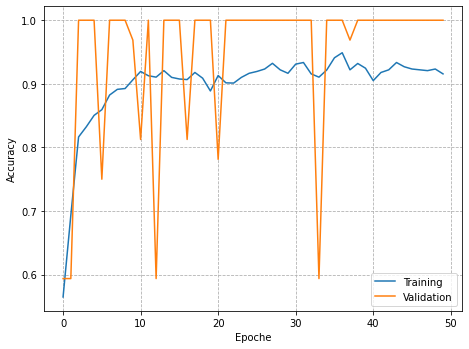

In [18]:
# Summarize history for accuracy
plt.figure(figsize=(7.49, 5.60))
plt.grid(linestyle='--')
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoche')
plt.legend(['Training', 'Validation'], loc='lower right')
#plt.savefig(history_acc_path)
plt.show()

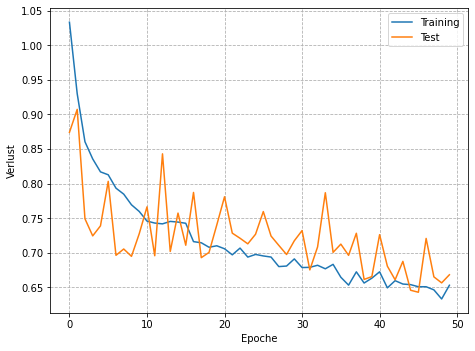

In [19]:
# Summarize history for loss
plt.figure(figsize=(7.49, 5.60))
plt.grid(linestyle='--')
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylabel('Verlust')
plt.xlabel('Epoche')
plt.legend(['Training', 'Test'], loc='upper right')
plt.show()

## ROC Kurve

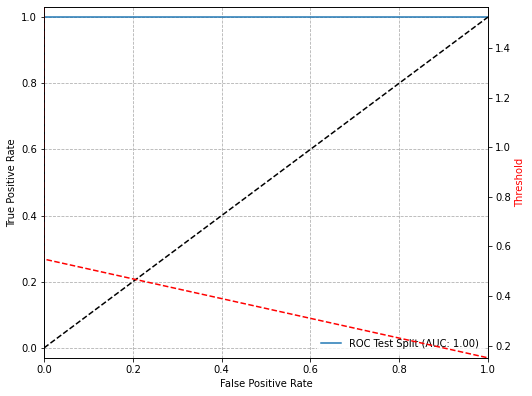

In [20]:
# Compute ROC curve
fprT, tprT, thres = roc_curve(labels_classes, pred_probas[:,1])

# Plot ROC curve
plt.figure(figsize=(7.49, 5.60))
plt.grid(linestyle='--')
plt.plot(fprT, tprT, label='ROC Test Split (AUC: %.2f)' %  roc_auc_score(labels_classes, pred_probas[:,1]))
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", facecolor='white', edgecolor='white')

# Plot thresholds
ax2 = plt.gca().twinx()
ax2.plot(fprT, thres, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thres[-1],thres[0]])
ax2.set_xlim([fprT[0],fprT[-1]])

# Save and show figure
plt.tight_layout()
plt.savefig('roc_curve.svg')
plt.show()

## Guided Grad-CAM

In [21]:
tf.compat.v1.disable_eager_execution()

def build_model():
    return load_model(modelPath)

def build_guided_model():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model

def grad_cam(input_model, image, class_nr, layer_name):
    y_c = input_model.output[0, class_nr]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def guided_backprop(input_model, images, layer_name):
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

def deprocess_image_1(x):
    mean = [103.939, 116.779, 123.68]
    for axis in [0, 1, 2]:
        x[..., axis] += mean[axis]
    x = x[..., ::-1]
    x /= 256.
    return x

def deprocess_image_2(x):
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 1. / 64.

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [22]:
model = build_model()
guided_model = build_guided_model()

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
H, W = 350, 350
# Loop over the two classes
for class_nr in range(2):
    # Loop over the images in the test dataset
    for idx, x in enumerate(test_x_images):
        # If the image belongs to the specific class
        if test_labels[idx, class_nr] == 1.0: 
            preprocessed_input = np.asarray([test_x_images[idx]])
            gradcam = grad_cam(model, preprocessed_input, predictions[idx], layer_name='block5_conv3')
            gb = guided_backprop(guided_model, preprocessed_input, layer_name='block5_conv3')
            guided_gradcam = gb * gradcam[..., np.newaxis]

            plt.figure(figsize=(15, 5.5))
            plt.subplot(131)
            plt.title('Original Image')
            plt.axis('off')
            plt.imshow(deprocess_image_1(test_x_images[idx]))
            
            plt.subplot(132)
            plt.title('GradCAM')
            plt.axis('off')
            plt.imshow(deprocess_image_1(preprocessed_input[0]))
            plt.imshow(gradcam, cmap='jet', alpha=0.5)

            plt.subplot(133)
            plt.title('Guided GradCAM')
            plt.axis('off')
            plt.imshow(deprocess_image_2(np.flip(guided_gradcam[0], -1)))
            plt.tight_layout()
            
            # Save image
            img_path = heatmaps_path + test_files[idx][:-4] + \
                '_class-' + str(class_nr) + '_prob-' + str(round(pred_probas[idx, class_nr], 2)) + ".png"
            plt.savefig(img_path)
            plt.close()